In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# from google.colab import auth
# auth.authenticate_user()

In [3]:
# from googleapiclient.discovery import build

# # Build the Drive service
# service = build('drive', 'v3')

In [4]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import os
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.transforms import functional as t_F
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
root = '/content/drive/MyDrive/Colposcopy/Data/Patient records'
train_df = pd.read_excel('/content/drive/MyDrive/Colposcopy/Data/Patient records/Meta/train_Impression_based.xlsx', dtype = str)
test_df = pd.read_excel('/content/drive/MyDrive/Colposcopy/Data/Patient records/Meta/test_Impression_based.xlsx', dtype = str)

In [7]:
train_df.head()

,Patient ID,jpg_file,xlsx_file,Impression,BX1,BX2,Loc_BX1,Loc_BX2
0,18.58,18.58/18_58_A.JPG,18.58.xlsx,High grade,CIN3,NaN,12,NaN
1,18.160,18_160/18_160_A1.JPG,18.160.xlsx,Normal,CIN1,NaN,12,NaN
2,19.731,19.731/19_731_A3.JPG,19.731.xlsx,Low grade,NaN,NaN,NaN,NaN
3,19.229,19_229/19_229_A1.JPG,19.229.xlsx,Normal,NaN,NaN,NaN,NaN
4,19.23,19_23/19_23_A2.JPG,19.23.xlsx,High grade,CIN1,NaN,NaN,NaN


In [8]:
# class ColposcopyBaseDataset(Dataset):
#     def __init__(self, dataframe, root_dir, cropped_folder="Cropped Folder", image_size=224, augment=False):
#         self.data = dataframe.reset_index(drop=True)
#         self.root_dir = root_dir
#         self.cropped_folder = cropped_folder
#         self.data["label"] = (self.data["Impression"].str.lower() == "normal").astype(int)
#         self.augment = augment
#         self.image_size = image_size

#         # Base transform (resize + normalization)
#         self.base_transform = transforms.Compose([
#             transforms.Resize((image_size, image_size)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
#         ])

#         # Only define deterministic augmentations for training
#         self.rotations = [0, 90, 180, 270]
#         self.flips = [(False, False), (True, False), (False, True), (True, True)]
#         self.num_aug_per_image = len(self.rotations) * len(self.flips) if augment else 1

#     def __len__(self):
#         return len(self.data) * self.num_aug_per_image

#     def __getitem__(self, idx):
#         img_idx = idx // self.num_aug_per_image if self.augment else idx
#         aug_idx = idx % self.num_aug_per_image if self.augment else 0
#         row = self.data.iloc[img_idx]

#         img_path = os.path.join(self.root_dir, self.cropped_folder,
#                                 str(row["Patient ID"]), row["jpg_file"])
#         label = row["label"]
#         image = Image.open(img_path).convert("RGB")

#         # Apply deterministic augmentations only if augment=True
#         if self.augment:
#             rot = self.rotations[aug_idx // len(self.flips)]
#             hflip, vflip = self.flips[aug_idx % len(self.flips)]
#             if rot:
#                 image = image.rotate(rot)
#             if hflip:
#                 image = t_F.hflip(image)
#             if vflip:
#                 image = t_F.vflip(image)

#         image = self.base_transform(image)
#         return image, torch.tensor(label, dtype=torch.long)


In [9]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image

class ColposcopyCachedDataset(Dataset):
    """
    Preloads all images (and their augmentations if needed) into memory.
    - augment=True → 16 deterministic variants per image (4 rotations × 4 flips)
    - augment=False → only original resized + normalized image
    """
    def __init__(self, dataframe, root_dir, cropped_folder="Cropped Folder",
                 image_size=224, augment=False):
        self.data = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.cropped_folder = cropped_folder
        self.augment = augment

        self.data["label"] = (self.data["Impression"].str.lower() != "normal").astype(int)

        self.rotations = [0, 90, 180, 270]
        self.flips = [(False, False), (True, False), (False, True), (True, True)]
        self.augment_transforms = [(rot, flip) for rot in self.rotations for flip in self.flips]
        # print(self.augment_transforms)

        self.base_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        # Preload all images once
        self.cached_images, self.cached_labels = self._preload_all()

    def _load_image(self, img_path):
        """Safely open an image and convert to RGB"""
        with Image.open(img_path) as img:
            return img.convert("RGB")

    def _preload_all(self):
        """Load all images (+ augmentations if requested) into memory"""
        images, labels = [], []

        for _, row in self.data.iterrows():
            label = torch.tensor(row["label"], dtype=torch.long)
            img_path = os.path.join(self.root_dir, self.cropped_folder,
                                    str(row["Patient ID"]), row["jpg_file"])
            try:
                image = self._load_image(img_path)
            except Exception as e:
                print(f"⚠️ Error loading {img_path}: {e}")
                continue

            if self.augment:
                augment_idx = [0]+ np.random.choice(range(16), size= self.augment-1, replace=False).tolist()
                for idx in augment_idx:
                    rot, (hflip, vflip) = self.augment_transforms[idx]
                    aug_img = image.copy()
                    if rot:
                        aug_img = aug_img.rotate(rot)
                    if hflip:
                        aug_img = t_F.hflip(aug_img)
                    if vflip:
                        aug_img = t_F.vflip(aug_img)
                    tensor_img = self.base_transform(aug_img)
                    images.append(tensor_img)
                    labels.append(label)
            else:
                tensor_img = self.base_transform(image)
                images.append(tensor_img)
                labels.append(label)

        print(f"✅ Cached {len(images)} tensors "
              f"({len(images)//len(self.data)}× per original)")
        return images, labels

    def __len__(self):
        return len(self.cached_images)

    def __getitem__(self, idx):
        return self.cached_images[idx], self.cached_labels[idx]

In [10]:
class Bsaic_Dataset(Dataset):
    def __init__(self, features, labels):
        # Convert numpy arrays to torch tensors
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [11]:
from torch.utils.data import random_split, DataLoader
import torch

batch_size=16
split_ratio=0.7
image_size=224


# Build datasets
train_dataset = ColposcopyCachedDataset(train_df, root, augment= 4, image_size=image_size)
test_dataset = ColposcopyCachedDataset(test_df, root, augment=False, image_size=image_size)

# Build dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

✅ Cached 1272 tensors (4× per original)
✅ Cached 106 tensors (1× per original)


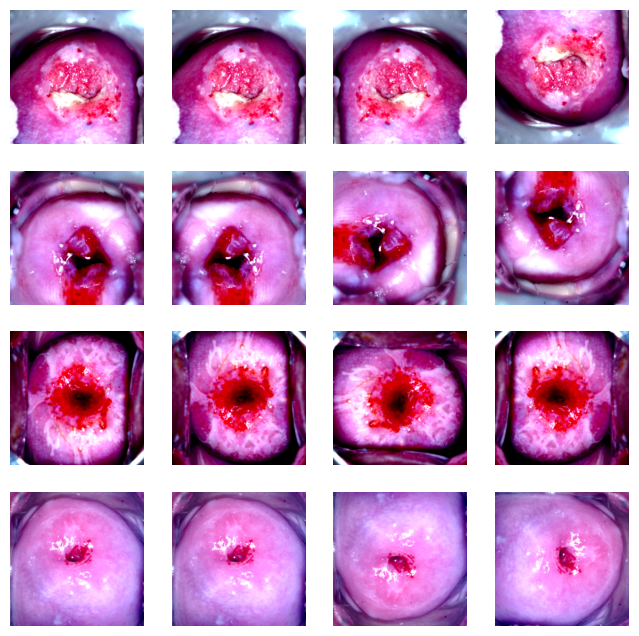

In [12]:
import matplotlib.pyplot as plt

def show_all_augmentations(dataset, img_idx):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(16):
        img, _ = dataset[img_idx * 16 + i]
        axes[i // 4, i % 4].imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        axes[i // 4, i % 4].axis('off')
    plt.show()

show_all_augmentations(train_dataset, 0)


### base model

In [13]:
def build_vgg16(num_classes=2):
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for param in model.features.parameters():
        param.requires_grad = False  # freeze backbone
    dim = 4096
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

def build_resnet152(num_classes=2):
    model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
    for param in list(model.children())[:-1]:
        for p in param.parameters():
            p.requires_grad = False
    dim = model.fc.in_features
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

### model with PCA

In [14]:
def build_vgg16_feature_extractor():
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for param in model.features.parameters():
        param.requires_grad = False  # freeze backbone
    dim =  model.classifier[6].in_features
    model.classifier[6] = nn.Identity()
    return model, dim

def build_resnet152_feature_extractor():
    model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
    for param in list(model.children())[:-1]:
        for p in param.parameters():
            p.requires_grad = False
    dim = model.fc.in_features
    model.fc = nn.Identity()
    return model, dim

In [15]:
def extract_features(dataloader, feature_extractor, device="cuda"):
    features, labels = [], []
    feature_extractor.to(device)
    feature_extractor.eval()
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            feats = feature_extractor(imgs)
            feats = feats.view(feats.size(0), -1)  # flatten
            features.append(feats.cpu().numpy())
            labels.append(lbls.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

In [16]:
from sklearn.decomposition import PCA

def apply_pca(train_feats, test_feats, pca, n_components=128):

    train_pca = pca.fit_transform(train_feats)
    test_pca = pca.transform(test_feats)
    explained = np.sum(pca.explained_variance_ratio_) * 100
    print(f"PCA reduced dimension → {n_components}, preserving {explained:.2f}% variance")
    return train_pca, test_pca, pca


In [17]:
# model, dim = build_vgg16_feature_extractor()
model, dim = build_resnet152_feature_extractor()

train_feats, train_labels = extract_features(train_loader, model)
test_feats, test_labels = extract_features(test_loader, model)

pca_dim = 128
pca = PCA(n_components=pca_dim, whiten=True, random_state=42)


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:01<00:00, 191MB/s]


In [18]:
train_pca, test_pca, pca = apply_pca(train_feats, test_feats, pca, n_components=128)

PCA reduced dimension → 128, preserving 93.70% variance


In [19]:
# Build datasets
train_dataset_pca = Bsaic_Dataset(train_pca, train_labels)
test_dataset_pca = Bsaic_Dataset(test_pca, test_labels)

# Build dataloaders
train_loader_pca = DataLoader(train_dataset_pca, batch_size=16, shuffle=True, num_workers=0)
test_loader_pca  = DataLoader(test_dataset_pca, batch_size=32, shuffle=False, num_workers=0)


In [20]:
import torch.nn as nn
import torch.nn.functional as F

class PCAHead(nn.Module):
    def __init__(self, input_dim, num_classes=2, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x


class PCAHead2(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=2, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        return self.fc2(x)


class PCAHead3(nn.Module):
    def __init__(self, input_dim, hidden_dim1=32,  hidden_dim2=32, num_classes=2, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.drop1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.drop2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        return self.fc3(x)


class PCAHeadN(nn.Module):
    def __init__(self, input_dim, hidden_dims = [], num_classes=2, dropout=0.5):
        super().__init__()
        self.dims = [input_dim] + hidden_dims + [num_classes]
        self.layers = nn.ModuleList()
        for i in range(len(self.dims)-1):
            self.layers.append(nn.Linear(self.dims[i], self.dims[i+1]))
            self.layers.append(nn.Dropout(dropout))
            self.layers.append(nn.ReLU())
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class layer_bloch(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.5):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc(x)
        x = self.drop(x)
        x = self.relu(x)
        return x

class PCAHeadN_res(nn.Module):
    def __init__(self, input_dim, hidden_dims = [], num_classes=2, dropout=0.5):
        super().__init__()
        self.dims = [input_dim] + hidden_dims + [num_classes]
        self.layers = nn.ModuleList()
        for i in range(len(self.dims)-1):
            self.layers.append(layer_bloch(self.dims[i], self.dims[i+1], dropout))

    def forward(self, x):
        for i in range(len(self.layers)):
            if self.dims[i] == self.dims:
                x = self.layers[i](x) + x
            else:
                x = self.layers[i](x)
        return x

# Training

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def evaluate_and_confusion(model, loader, device="cuda", title="Confusion Matrix"):
    """Compute predictions, true labels, and plot confusion matrix."""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Normal", "Normal"])
    disp.plot(cmap=plt.cm.Blues, values_format=".2f")
    plt.title(title)
    plt.show()

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return acc, cm


In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_side_by_side_confusions(model_best, model_last, loader, title_prefix=""):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    class_names = ["Normal", "Abnormal"]

    for ax, model, title in zip(
        axes, [model_best, model_last], [f"{title_prefix} Best", f"{title_prefix} Last"]
    ):
        model.eval()
        model.to("cuda")

        all_preds, all_labels = [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.cuda(), labels.cuda()
                preds = model(imgs).argmax(1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        cm_counts = confusion_matrix(all_labels, all_preds)
        cm_norm = cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True)

        # ---- Draw matrix background ----
        im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(title)
        ax.set_xticks(np.arange(len(class_names)))
        ax.set_yticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names)
        ax.set_yticklabels(class_names)
        ax.set_ylabel("True label")
        ax.set_xlabel("Predicted label")

        # ---- Overlay text (percent + count) ----
        for i in range(cm_counts.shape[0]):
            for j in range(cm_counts.shape[1]):
                ax.text(
                    j, i,
                    f"{cm_norm[i, j]*100:.1f}%\n({cm_counts[i, j]})",
                    ha="center", va="center",
                    color="black", fontsize=10, fontweight="bold"
                )

    plt.tight_layout()
    plt.show()


In [23]:
def evaluate_model(model, loader, device="cuda"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [105]:
def train_model(model, train_loader, test_loader, epochs=10, lr=1e-4, device="cuda", save_name="model", f_CE_weights = None):
    model.to(device)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    best_acc = 0.0
    best_model_state = None
    train_acc_list, test_acc_list = [], []


    for epoch in range(epochs):
        # ===== Train =====
        model.train()
        correct, total, running_loss = 0, 0, 0.0

        # if epoch < 50: criterion.weight = torch.tensor([100.0, 1]).to(device)
        # elif epoch < 100: criterion.weight = torch.tensor([10.0, 1]).to(device)
        # else: criterion.weight = torch.tensor([1.0, 1]).to(device)
        if f_CE_weights is not None:
            criterion.weight = torch.tensor([f(epoch, epochs), 1], dtype = torch.float).to(device)


        for imgs, labels in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # ======== FULL EVALUATION ON TRAIN SET ========
        train_acc = evaluate_model(model, train_loader, device)
        train_acc_list.append(train_acc)

        # ======== FULL EVALUATION ON TEST SET ========
        test_acc = evaluate_model(model, test_loader, device)
        test_acc_list.append(test_acc)
        print(f"Epoch [{epoch+1}/{epochs}] | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

        # ===== Track Best Model =====
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), f"{save_name}_best.pt")
            # best_model_state = model.state_dict().copy()

    # Save last and best model
    torch.save(model.state_dict(), f"{save_name}_last.pt")
    # if best_model_state is not None:
    #     torch.save(best_model_state, f"{save_name}_best.pt")

    print(f"✅ Best Test Accuracy: {best_acc:.4f}")
    return train_acc_list, test_acc_list


### train base models

In [39]:
# # Example: VGG16
# vgg = build_vgg16()
# vgg_train_acc, vgg_test_acc = train_model(
#     vgg, train_loader, test_loader, epochs=10, device="cuda", save_name="vgg16"
# )

In [40]:
# vgg_best = build_vgg16()
# vgg_best.load_state_dict(torch.load("vgg16_best.pt"))

# vgg_last = build_vgg16()
# vgg_last.load_state_dict(torch.load("vgg16_last.pt"))

In [41]:
# plot_side_by_side_confusions(vgg_best, vgg_last, test_loader, "VGG16 (Test)")
# plot_side_by_side_confusions(vgg_best, vgg_last, train_loader, "VGG16 (Test)")

In [42]:
# plt.plot(vgg_train_acc, label="VGG16 Train")
# plt.plot(vgg_test_acc, label="VGG16 Test")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

In [43]:
# resnet = build_resnet152()
# resnet_train_acc, resnet_test_acc = train_model(
#     resnet, train_loader, test_loader, epochs=15, device="cuda", save_name="resnet", lr= 5e-4
# )

In [44]:
# resnet_best = build_resnet152()
# resnet_best.load_state_dict(torch.load("resnet_best.pt"))

# resnet_last = build_resnet152()
# resnet_last.load_state_dict(torch.load("resnet_last.pt"))


In [45]:
# plot_side_by_side_confusions(resnet_best, resnet_last, test_loader, "resnet (Test)")
# plot_side_by_side_confusions(resnet_best, resnet_last, train_loader, "resnet (Test)")

In [46]:

# plt.plot(resnet_train_acc, label="ResNet152 Train")
# plt.plot(resnet_test_acc, label="ResNet152 Test")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

### train PCA models

In [64]:
Head = PCAHeadN
args = {'input_dim':train_pca.shape[1],
        'num_classes':2,
        'hidden_dims':[]}
model_head = Head(**args).to(device)
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(torch.tensor([10, 1]).to(device))

In [65]:
train_acc, test_acc = train_model(
    model_head, train_loader_pca, test_loader_pca, epochs=100, device="cuda", save_name="model_pca"
)

[Train] Epoch 1/100: 100%|██████████| 80/80 [00:00<00:00, 219.94it/s]


Epoch [1/100] | Train Acc: 0.4725 | Test Acc: 0.4906


[Train] Epoch 2/100: 100%|██████████| 80/80 [00:00<00:00, 269.17it/s]


Epoch [2/100] | Train Acc: 0.4725 | Test Acc: 0.4906


[Train] Epoch 3/100: 100%|██████████| 80/80 [00:00<00:00, 319.62it/s]


Epoch [3/100] | Train Acc: 0.4788 | Test Acc: 0.4906


[Train] Epoch 4/100: 100%|██████████| 80/80 [00:00<00:00, 264.14it/s]


Epoch [4/100] | Train Acc: 0.4890 | Test Acc: 0.4906


[Train] Epoch 5/100: 100%|██████████| 80/80 [00:00<00:00, 324.88it/s]


Epoch [5/100] | Train Acc: 0.4961 | Test Acc: 0.4906


[Train] Epoch 6/100: 100%|██████████| 80/80 [00:00<00:00, 370.63it/s]


Epoch [6/100] | Train Acc: 0.4992 | Test Acc: 0.4906


[Train] Epoch 7/100: 100%|██████████| 80/80 [00:00<00:00, 312.46it/s]


Epoch [7/100] | Train Acc: 0.5031 | Test Acc: 0.4811


[Train] Epoch 8/100: 100%|██████████| 80/80 [00:00<00:00, 306.13it/s]


Epoch [8/100] | Train Acc: 0.5047 | Test Acc: 0.4906


[Train] Epoch 9/100: 100%|██████████| 80/80 [00:00<00:00, 544.69it/s]


Epoch [9/100] | Train Acc: 0.5102 | Test Acc: 0.4906


[Train] Epoch 10/100: 100%|██████████| 80/80 [00:00<00:00, 197.79it/s]


Epoch [10/100] | Train Acc: 0.5157 | Test Acc: 0.4811


[Train] Epoch 11/100: 100%|██████████| 80/80 [00:00<00:00, 284.33it/s]


Epoch [11/100] | Train Acc: 0.5181 | Test Acc: 0.4811


[Train] Epoch 12/100: 100%|██████████| 80/80 [00:00<00:00, 556.53it/s]


Epoch [12/100] | Train Acc: 0.5228 | Test Acc: 0.4717


[Train] Epoch 13/100: 100%|██████████| 80/80 [00:00<00:00, 569.21it/s]


Epoch [13/100] | Train Acc: 0.5259 | Test Acc: 0.4717


[Train] Epoch 14/100: 100%|██████████| 80/80 [00:00<00:00, 554.87it/s]


Epoch [14/100] | Train Acc: 0.5330 | Test Acc: 0.4811


[Train] Epoch 15/100: 100%|██████████| 80/80 [00:00<00:00, 596.98it/s]


Epoch [15/100] | Train Acc: 0.5354 | Test Acc: 0.4906


[Train] Epoch 16/100: 100%|██████████| 80/80 [00:00<00:00, 654.77it/s]


Epoch [16/100] | Train Acc: 0.5417 | Test Acc: 0.4906


[Train] Epoch 17/100: 100%|██████████| 80/80 [00:00<00:00, 830.21it/s]


Epoch [17/100] | Train Acc: 0.5425 | Test Acc: 0.5189


[Train] Epoch 18/100: 100%|██████████| 80/80 [00:00<00:00, 832.23it/s]


Epoch [18/100] | Train Acc: 0.5503 | Test Acc: 0.5189


[Train] Epoch 19/100: 100%|██████████| 80/80 [00:00<00:00, 816.56it/s]


Epoch [19/100] | Train Acc: 0.5511 | Test Acc: 0.5094


[Train] Epoch 20/100: 100%|██████████| 80/80 [00:00<00:00, 839.51it/s]


Epoch [20/100] | Train Acc: 0.5558 | Test Acc: 0.5094


[Train] Epoch 21/100: 100%|██████████| 80/80 [00:00<00:00, 808.62it/s]


Epoch [21/100] | Train Acc: 0.5605 | Test Acc: 0.5283


[Train] Epoch 22/100: 100%|██████████| 80/80 [00:00<00:00, 831.15it/s]


Epoch [22/100] | Train Acc: 0.5653 | Test Acc: 0.5377


[Train] Epoch 23/100: 100%|██████████| 80/80 [00:00<00:00, 811.40it/s]


Epoch [23/100] | Train Acc: 0.5731 | Test Acc: 0.5472


[Train] Epoch 24/100: 100%|██████████| 80/80 [00:00<00:00, 810.58it/s]


Epoch [24/100] | Train Acc: 0.5763 | Test Acc: 0.5472


[Train] Epoch 25/100: 100%|██████████| 80/80 [00:00<00:00, 839.74it/s]


Epoch [25/100] | Train Acc: 0.5794 | Test Acc: 0.5377


[Train] Epoch 26/100: 100%|██████████| 80/80 [00:00<00:00, 824.86it/s]


Epoch [26/100] | Train Acc: 0.5818 | Test Acc: 0.5377


[Train] Epoch 27/100: 100%|██████████| 80/80 [00:00<00:00, 838.86it/s]


Epoch [27/100] | Train Acc: 0.5904 | Test Acc: 0.5377


[Train] Epoch 28/100: 100%|██████████| 80/80 [00:00<00:00, 816.08it/s]


Epoch [28/100] | Train Acc: 0.5975 | Test Acc: 0.5566


[Train] Epoch 29/100: 100%|██████████| 80/80 [00:00<00:00, 830.60it/s]


Epoch [29/100] | Train Acc: 0.6093 | Test Acc: 0.5755


[Train] Epoch 30/100: 100%|██████████| 80/80 [00:00<00:00, 826.60it/s]


Epoch [30/100] | Train Acc: 0.6101 | Test Acc: 0.5566


[Train] Epoch 31/100: 100%|██████████| 80/80 [00:00<00:00, 736.37it/s]


Epoch [31/100] | Train Acc: 0.6140 | Test Acc: 0.5472


[Train] Epoch 32/100: 100%|██████████| 80/80 [00:00<00:00, 828.90it/s]


Epoch [32/100] | Train Acc: 0.6148 | Test Acc: 0.5660


[Train] Epoch 33/100: 100%|██████████| 80/80 [00:00<00:00, 821.29it/s]


Epoch [33/100] | Train Acc: 0.6203 | Test Acc: 0.5660


[Train] Epoch 34/100: 100%|██████████| 80/80 [00:00<00:00, 820.77it/s]


Epoch [34/100] | Train Acc: 0.6258 | Test Acc: 0.5566


[Train] Epoch 35/100: 100%|██████████| 80/80 [00:00<00:00, 833.50it/s]


Epoch [35/100] | Train Acc: 0.6242 | Test Acc: 0.5566


[Train] Epoch 36/100: 100%|██████████| 80/80 [00:00<00:00, 843.51it/s]


Epoch [36/100] | Train Acc: 0.6289 | Test Acc: 0.5566


[Train] Epoch 37/100: 100%|██████████| 80/80 [00:00<00:00, 811.57it/s]


Epoch [37/100] | Train Acc: 0.6344 | Test Acc: 0.5566


[Train] Epoch 38/100: 100%|██████████| 80/80 [00:00<00:00, 723.41it/s]


Epoch [38/100] | Train Acc: 0.6344 | Test Acc: 0.5660


[Train] Epoch 39/100: 100%|██████████| 80/80 [00:00<00:00, 805.97it/s]


Epoch [39/100] | Train Acc: 0.6376 | Test Acc: 0.5566


[Train] Epoch 40/100: 100%|██████████| 80/80 [00:00<00:00, 810.55it/s]


Epoch [40/100] | Train Acc: 0.6415 | Test Acc: 0.5566


[Train] Epoch 41/100: 100%|██████████| 80/80 [00:00<00:00, 811.92it/s]


Epoch [41/100] | Train Acc: 0.6454 | Test Acc: 0.5472


[Train] Epoch 42/100: 100%|██████████| 80/80 [00:00<00:00, 809.48it/s]


Epoch [42/100] | Train Acc: 0.6470 | Test Acc: 0.5472


[Train] Epoch 43/100: 100%|██████████| 80/80 [00:00<00:00, 835.19it/s]


Epoch [43/100] | Train Acc: 0.6541 | Test Acc: 0.5566


[Train] Epoch 44/100: 100%|██████████| 80/80 [00:00<00:00, 824.21it/s]


Epoch [44/100] | Train Acc: 0.6572 | Test Acc: 0.5755


[Train] Epoch 45/100: 100%|██████████| 80/80 [00:00<00:00, 805.15it/s]


Epoch [45/100] | Train Acc: 0.6588 | Test Acc: 0.5755


[Train] Epoch 46/100: 100%|██████████| 80/80 [00:00<00:00, 821.64it/s]


Epoch [46/100] | Train Acc: 0.6635 | Test Acc: 0.5849


[Train] Epoch 47/100: 100%|██████████| 80/80 [00:00<00:00, 807.91it/s]


Epoch [47/100] | Train Acc: 0.6667 | Test Acc: 0.5849


[Train] Epoch 48/100: 100%|██████████| 80/80 [00:00<00:00, 826.55it/s]


Epoch [48/100] | Train Acc: 0.6682 | Test Acc: 0.5849


[Train] Epoch 49/100: 100%|██████████| 80/80 [00:00<00:00, 834.36it/s]


Epoch [49/100] | Train Acc: 0.6698 | Test Acc: 0.5943


[Train] Epoch 50/100: 100%|██████████| 80/80 [00:00<00:00, 833.75it/s]


Epoch [50/100] | Train Acc: 0.6730 | Test Acc: 0.5943


[Train] Epoch 51/100: 100%|██████████| 80/80 [00:00<00:00, 832.82it/s]


Epoch [51/100] | Train Acc: 0.6745 | Test Acc: 0.6038


[Train] Epoch 52/100: 100%|██████████| 80/80 [00:00<00:00, 839.22it/s]


Epoch [52/100] | Train Acc: 0.6769 | Test Acc: 0.6038


[Train] Epoch 53/100: 100%|██████████| 80/80 [00:00<00:00, 731.47it/s]


Epoch [53/100] | Train Acc: 0.6808 | Test Acc: 0.6038


[Train] Epoch 54/100: 100%|██████████| 80/80 [00:00<00:00, 824.81it/s]


Epoch [54/100] | Train Acc: 0.6808 | Test Acc: 0.6132


[Train] Epoch 55/100: 100%|██████████| 80/80 [00:00<00:00, 830.34it/s]


Epoch [55/100] | Train Acc: 0.6816 | Test Acc: 0.6132


[Train] Epoch 56/100: 100%|██████████| 80/80 [00:00<00:00, 819.59it/s]


Epoch [56/100] | Train Acc: 0.6840 | Test Acc: 0.6038


[Train] Epoch 57/100: 100%|██████████| 80/80 [00:00<00:00, 837.08it/s]


Epoch [57/100] | Train Acc: 0.6879 | Test Acc: 0.6226


[Train] Epoch 58/100: 100%|██████████| 80/80 [00:00<00:00, 836.68it/s]


Epoch [58/100] | Train Acc: 0.6847 | Test Acc: 0.6226


[Train] Epoch 59/100: 100%|██████████| 80/80 [00:00<00:00, 838.64it/s]


Epoch [59/100] | Train Acc: 0.6847 | Test Acc: 0.6321


[Train] Epoch 60/100: 100%|██████████| 80/80 [00:00<00:00, 724.79it/s]


Epoch [60/100] | Train Acc: 0.6863 | Test Acc: 0.6415


[Train] Epoch 61/100: 100%|██████████| 80/80 [00:00<00:00, 852.76it/s]


Epoch [61/100] | Train Acc: 0.6910 | Test Acc: 0.6415


[Train] Epoch 62/100: 100%|██████████| 80/80 [00:00<00:00, 852.17it/s]


Epoch [62/100] | Train Acc: 0.6895 | Test Acc: 0.6415


[Train] Epoch 63/100: 100%|██████████| 80/80 [00:00<00:00, 842.80it/s]


Epoch [63/100] | Train Acc: 0.6863 | Test Acc: 0.6415


[Train] Epoch 64/100: 100%|██████████| 80/80 [00:00<00:00, 836.59it/s]


Epoch [64/100] | Train Acc: 0.6855 | Test Acc: 0.6415


[Train] Epoch 65/100: 100%|██████████| 80/80 [00:00<00:00, 840.40it/s]


Epoch [65/100] | Train Acc: 0.6903 | Test Acc: 0.6415


[Train] Epoch 66/100: 100%|██████████| 80/80 [00:00<00:00, 826.36it/s]


Epoch [66/100] | Train Acc: 0.6879 | Test Acc: 0.6415


[Train] Epoch 67/100: 100%|██████████| 80/80 [00:00<00:00, 847.30it/s]


Epoch [67/100] | Train Acc: 0.6903 | Test Acc: 0.6415


[Train] Epoch 68/100: 100%|██████████| 80/80 [00:00<00:00, 748.57it/s]


Epoch [68/100] | Train Acc: 0.6942 | Test Acc: 0.6509


[Train] Epoch 69/100: 100%|██████████| 80/80 [00:00<00:00, 837.99it/s]


Epoch [69/100] | Train Acc: 0.6950 | Test Acc: 0.6415


[Train] Epoch 70/100: 100%|██████████| 80/80 [00:00<00:00, 827.71it/s]


Epoch [70/100] | Train Acc: 0.6965 | Test Acc: 0.6415


[Train] Epoch 71/100: 100%|██████████| 80/80 [00:00<00:00, 829.73it/s]


Epoch [71/100] | Train Acc: 0.7036 | Test Acc: 0.6415


[Train] Epoch 72/100: 100%|██████████| 80/80 [00:00<00:00, 825.37it/s]


Epoch [72/100] | Train Acc: 0.7044 | Test Acc: 0.6415


[Train] Epoch 73/100: 100%|██████████| 80/80 [00:00<00:00, 633.29it/s]


Epoch [73/100] | Train Acc: 0.7044 | Test Acc: 0.6415


[Train] Epoch 74/100: 100%|██████████| 80/80 [00:00<00:00, 622.22it/s]


Epoch [74/100] | Train Acc: 0.7028 | Test Acc: 0.6415


[Train] Epoch 75/100: 100%|██████████| 80/80 [00:00<00:00, 642.03it/s]


Epoch [75/100] | Train Acc: 0.7036 | Test Acc: 0.6415


[Train] Epoch 76/100: 100%|██████████| 80/80 [00:00<00:00, 679.48it/s]


Epoch [76/100] | Train Acc: 0.7052 | Test Acc: 0.6415


[Train] Epoch 77/100: 100%|██████████| 80/80 [00:00<00:00, 707.78it/s]


Epoch [77/100] | Train Acc: 0.7131 | Test Acc: 0.6509


[Train] Epoch 78/100: 100%|██████████| 80/80 [00:00<00:00, 703.11it/s]


Epoch [78/100] | Train Acc: 0.7075 | Test Acc: 0.6509


[Train] Epoch 79/100: 100%|██████████| 80/80 [00:00<00:00, 717.70it/s]


Epoch [79/100] | Train Acc: 0.7075 | Test Acc: 0.6509


[Train] Epoch 80/100: 100%|██████████| 80/80 [00:00<00:00, 715.83it/s]


Epoch [80/100] | Train Acc: 0.7099 | Test Acc: 0.6509


[Train] Epoch 81/100: 100%|██████████| 80/80 [00:00<00:00, 531.17it/s]


Epoch [81/100] | Train Acc: 0.7091 | Test Acc: 0.6698


[Train] Epoch 82/100: 100%|██████████| 80/80 [00:00<00:00, 699.20it/s]


Epoch [82/100] | Train Acc: 0.7138 | Test Acc: 0.6698


[Train] Epoch 83/100: 100%|██████████| 80/80 [00:00<00:00, 704.99it/s]


Epoch [83/100] | Train Acc: 0.7123 | Test Acc: 0.6698


[Train] Epoch 84/100: 100%|██████████| 80/80 [00:00<00:00, 742.01it/s]


Epoch [84/100] | Train Acc: 0.7154 | Test Acc: 0.6698


[Train] Epoch 85/100: 100%|██████████| 80/80 [00:00<00:00, 742.98it/s]


Epoch [85/100] | Train Acc: 0.7154 | Test Acc: 0.6604


[Train] Epoch 86/100: 100%|██████████| 80/80 [00:00<00:00, 600.75it/s]


Epoch [86/100] | Train Acc: 0.7123 | Test Acc: 0.6698


[Train] Epoch 87/100: 100%|██████████| 80/80 [00:00<00:00, 519.56it/s]


Epoch [87/100] | Train Acc: 0.7115 | Test Acc: 0.6604


[Train] Epoch 88/100: 100%|██████████| 80/80 [00:00<00:00, 577.45it/s]


Epoch [88/100] | Train Acc: 0.7154 | Test Acc: 0.6604


[Train] Epoch 89/100: 100%|██████████| 80/80 [00:00<00:00, 628.33it/s]


Epoch [89/100] | Train Acc: 0.7146 | Test Acc: 0.6698


[Train] Epoch 90/100: 100%|██████████| 80/80 [00:00<00:00, 665.76it/s]


Epoch [90/100] | Train Acc: 0.7138 | Test Acc: 0.6698


[Train] Epoch 91/100: 100%|██████████| 80/80 [00:00<00:00, 824.93it/s]


Epoch [91/100] | Train Acc: 0.7178 | Test Acc: 0.6698


[Train] Epoch 92/100: 100%|██████████| 80/80 [00:00<00:00, 836.52it/s]


Epoch [92/100] | Train Acc: 0.7146 | Test Acc: 0.6698


[Train] Epoch 93/100: 100%|██████████| 80/80 [00:00<00:00, 714.03it/s]


Epoch [93/100] | Train Acc: 0.7201 | Test Acc: 0.6792


[Train] Epoch 94/100: 100%|██████████| 80/80 [00:00<00:00, 819.88it/s]


Epoch [94/100] | Train Acc: 0.7178 | Test Acc: 0.6698


[Train] Epoch 95/100: 100%|██████████| 80/80 [00:00<00:00, 854.43it/s]


Epoch [95/100] | Train Acc: 0.7201 | Test Acc: 0.6698


[Train] Epoch 96/100: 100%|██████████| 80/80 [00:00<00:00, 841.16it/s]


Epoch [96/100] | Train Acc: 0.7201 | Test Acc: 0.6698


[Train] Epoch 97/100: 100%|██████████| 80/80 [00:00<00:00, 835.20it/s]


Epoch [97/100] | Train Acc: 0.7201 | Test Acc: 0.6698


[Train] Epoch 98/100: 100%|██████████| 80/80 [00:00<00:00, 837.29it/s]


Epoch [98/100] | Train Acc: 0.7201 | Test Acc: 0.6698


[Train] Epoch 99/100: 100%|██████████| 80/80 [00:00<00:00, 842.47it/s]


Epoch [99/100] | Train Acc: 0.7217 | Test Acc: 0.6698


[Train] Epoch 100/100: 100%|██████████| 80/80 [00:00<00:00, 783.47it/s]

Epoch [100/100] | Train Acc: 0.7256 | Test Acc: 0.6604
✅ Best Test Accuracy: 0.6792


In [66]:
model_best = Head(**args).to("cuda")
model_best.load_state_dict(torch.load("model_pca_best.pt"))

model_last = Head(**args).to("cuda")
model_last.load_state_dict(torch.load("model_pca_last.pt"))

<All keys matched successfully>

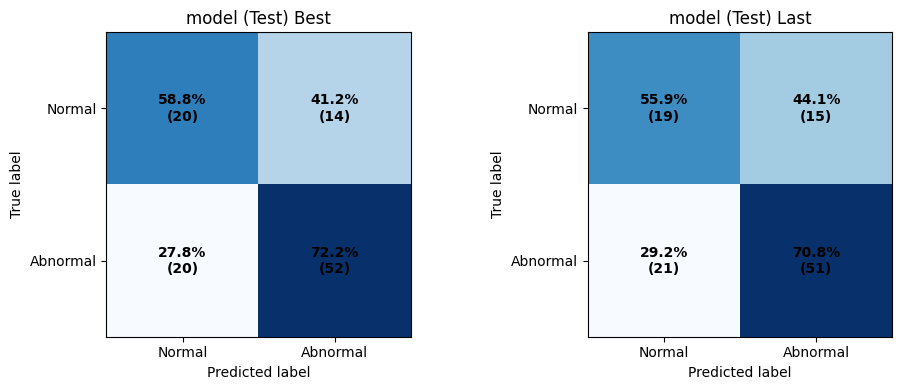

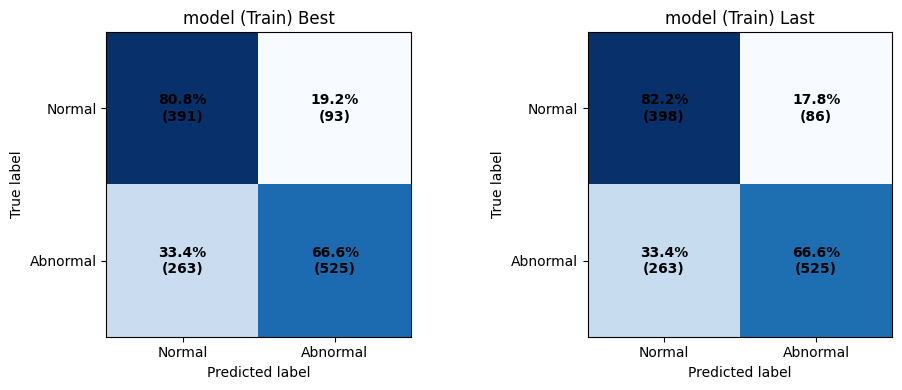

In [67]:
plot_side_by_side_confusions(model_best, model_last, test_loader_pca, "model (Test)")
plot_side_by_side_confusions(model_best, model_last, train_loader_pca, "model (Train)")

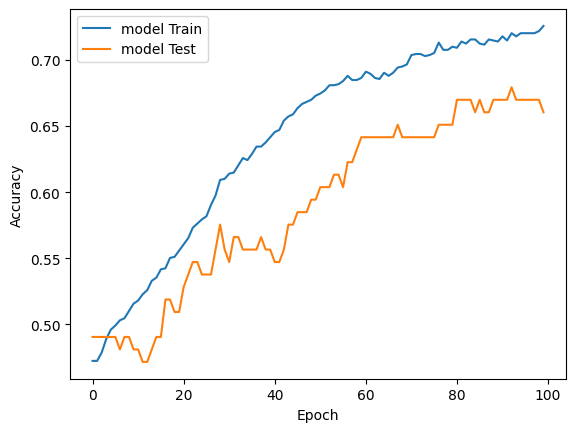

In [68]:
plt.plot(train_acc, label="model Train")
plt.plot(test_acc, label="model Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Train PCA based model

In [106]:
pca_matrix = torch.tensor(pca.components_, dtype=torch.float32)

class PCARegularizedModel(nn.Module):
    def __init__(self, input_dim, pca_dim, num_classes, pca_matrix):
        super().__init__()

        # Learnable projection initialized randomly
        self.proj = nn.Linear(input_dim, pca_dim, bias=False)

        # PCA matrix from sklearn (frozen)
        self.pca_matrix = nn.Parameter(pca_matrix.clone(), requires_grad=False)

        self.proj.weight.data = pca_matrix.clone()

        self.classifier = nn.Linear(pca_dim, num_classes)

    def forward(self, feats):
        z = self.proj(feats)
        return self.classifier(z)

    def regularization_loss(self):
        return F.mse_loss(self.proj.weight, self.pca_matrix)


class PCARegularizedModel_LoRA(nn.Module):
    def __init__(self, input_dim, pca_dim, LoRA_dim, num_classes, pca_matrix):
        super().__init__()

        # Learnable projection initialized randomly
        self.LoRA_fc1 = nn.Linear(input_dim, LoRA_dim, bias=False)
        self.LoRa_fc2 = nn.Linear(LoRA_dim, pca_dim, bias=False)

        # PCA matrix from sklearn (frozen)
        self.pca_matrix = nn.Parameter(pca_matrix.clone(), requires_grad=False)

        self.classifier = nn.Linear(pca_dim, num_classes)

    def forward(self, feats):
        # PCA projection
        z_pca = feats @ self.pca_matrix.T   # (B, pca_dim)
        # LoRA residual ΔW x = B(A(x))
        z_lora = self.LoRa_fc2(self.LoRA_fc1(feats))
        # Combine
        z = z_pca + z_lora
        return self.classifier(z)


class Combined_loss(nn.Module):
    def __init__(self, model, coef=0.01, weight = None):
        super().__init__()
        self.model = model
        self.coef = coef
        self.ce_loss = nn.CrossEntropyLoss()
        self.weight = weight

    def forward(self, outputs, labels):
        if self.weight is not None:
            self.ce_loss.weight = self.weight.to(device)
        ce = self.ce_loss(outputs, labels)
        reg = self.model.regularization_loss()
        print(ce, reg)
        return ce + self.coef * reg

In [107]:
train_dataset_feats = Bsaic_Dataset(train_feats, train_labels)
test_dataset_feats = Bsaic_Dataset(test_feats, test_labels)

train_loader_feats = DataLoader(train_dataset_feats, batch_size=16, shuffle=True, num_workers=0)
test_loader_feats  = DataLoader(test_dataset_feats, batch_size=32, shuffle=False, num_workers=0)

In [149]:
args = {"input_dim": train_feats.shape[1], "pca_dim": pca_dim, "num_classes": 2, "pca_matrix": pca_matrix, "LoRA_dim": 4}
# args = {"input_dim": train_feats.shape[1], "pca_dim": pca_dim, "num_classes": 2, "pca_matrix": pca_matrix}
Head_class = PCARegularizedModel_LoRA
model = Head_class(**args)
# criterion = Combined_loss(model, coef=500)
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()


In [150]:
    # f = lambda epoch: 1 + 30/epochs * (epochs - epoch-1)
    # f = lambda x: 100*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-epochs/2))))
    # f = lambda x: 95*(1- torch.sigmoid(torch.tensor(0.2 *100/epochs *(x-epochs/2)))) + 5
    # f = lambda x: 200*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-4*epochs/5)))) + 20
    # f = lambda x: 200*(1- torch.sigmoid(torch.tensor(0.5 *100/epochs *(x-4*epochs/5)))) + 60
    # f = lambda x: 99*(x<0.9*epochs) + 1
    # f = lambda x: 10
    # f = lambda x, y: 10*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2))))
    f = lambda x, y: 8*(1- torch.sigmoid(torch.tensor(0.3 *100/y *(x-y/2)))) + 3
    # f = lambda x: None


In [151]:
train_acc, test_acc = train_model(
    model, train_loader_feats, test_loader_feats, epochs=150, device="cuda", save_name="model_pca_reg", lr= 5e-5, f_CE_weights= f)

[Train] Epoch 1/150: 100%|██████████| 80/80 [00:00<00:00, 668.00it/s]


Epoch [1/150] | Train Acc: 0.3821 | Test Acc: 0.3302


[Train] Epoch 2/150: 100%|██████████| 80/80 [00:00<00:00, 653.38it/s]


Epoch [2/150] | Train Acc: 0.3805 | Test Acc: 0.3302


[Train] Epoch 3/150: 100%|██████████| 80/80 [00:00<00:00, 621.14it/s]


Epoch [3/150] | Train Acc: 0.3805 | Test Acc: 0.3208


[Train] Epoch 4/150: 100%|██████████| 80/80 [00:00<00:00, 663.80it/s]


Epoch [4/150] | Train Acc: 0.3813 | Test Acc: 0.3208


[Train] Epoch 5/150: 100%|██████████| 80/80 [00:00<00:00, 658.40it/s]


Epoch [5/150] | Train Acc: 0.3821 | Test Acc: 0.3208


[Train] Epoch 6/150: 100%|██████████| 80/80 [00:00<00:00, 669.93it/s]


Epoch [6/150] | Train Acc: 0.3821 | Test Acc: 0.3208


[Train] Epoch 7/150: 100%|██████████| 80/80 [00:00<00:00, 665.05it/s]


Epoch [7/150] | Train Acc: 0.3821 | Test Acc: 0.3208


[Train] Epoch 8/150: 100%|██████████| 80/80 [00:00<00:00, 664.96it/s]


Epoch [8/150] | Train Acc: 0.3821 | Test Acc: 0.3208


[Train] Epoch 9/150: 100%|██████████| 80/80 [00:00<00:00, 626.63it/s]


Epoch [9/150] | Train Acc: 0.3821 | Test Acc: 0.3208


[Train] Epoch 10/150: 100%|██████████| 80/80 [00:00<00:00, 676.68it/s]


Epoch [10/150] | Train Acc: 0.3844 | Test Acc: 0.3208


[Train] Epoch 11/150: 100%|██████████| 80/80 [00:00<00:00, 674.23it/s]


Epoch [11/150] | Train Acc: 0.3868 | Test Acc: 0.3302


[Train] Epoch 12/150: 100%|██████████| 80/80 [00:00<00:00, 662.37it/s]


Epoch [12/150] | Train Acc: 0.3868 | Test Acc: 0.3302


[Train] Epoch 13/150: 100%|██████████| 80/80 [00:00<00:00, 640.98it/s]


Epoch [13/150] | Train Acc: 0.3836 | Test Acc: 0.3302


[Train] Epoch 14/150: 100%|██████████| 80/80 [00:00<00:00, 660.60it/s]


Epoch [14/150] | Train Acc: 0.3876 | Test Acc: 0.3396


[Train] Epoch 15/150: 100%|██████████| 80/80 [00:00<00:00, 598.05it/s]


Epoch [15/150] | Train Acc: 0.4041 | Test Acc: 0.3491


[Train] Epoch 16/150: 100%|██████████| 80/80 [00:00<00:00, 666.21it/s]


Epoch [16/150] | Train Acc: 0.3978 | Test Acc: 0.3491


[Train] Epoch 17/150: 100%|██████████| 80/80 [00:00<00:00, 505.79it/s]


Epoch [17/150] | Train Acc: 0.4285 | Test Acc: 0.3585


[Train] Epoch 18/150: 100%|██████████| 80/80 [00:00<00:00, 553.70it/s]


Epoch [18/150] | Train Acc: 0.4064 | Test Acc: 0.3585


[Train] Epoch 19/150: 100%|██████████| 80/80 [00:00<00:00, 551.35it/s]


Epoch [19/150] | Train Acc: 0.4057 | Test Acc: 0.3491


[Train] Epoch 20/150: 100%|██████████| 80/80 [00:00<00:00, 513.76it/s]


Epoch [20/150] | Train Acc: 0.4159 | Test Acc: 0.3585


[Train] Epoch 21/150: 100%|██████████| 80/80 [00:00<00:00, 502.33it/s]


Epoch [21/150] | Train Acc: 0.4426 | Test Acc: 0.3491


[Train] Epoch 22/150: 100%|██████████| 80/80 [00:00<00:00, 541.62it/s]


Epoch [22/150] | Train Acc: 0.4536 | Test Acc: 0.3585


[Train] Epoch 23/150: 100%|██████████| 80/80 [00:00<00:00, 565.10it/s]


Epoch [23/150] | Train Acc: 0.4112 | Test Acc: 0.3585


[Train] Epoch 24/150: 100%|██████████| 80/80 [00:00<00:00, 573.41it/s]


Epoch [24/150] | Train Acc: 0.4497 | Test Acc: 0.3679


[Train] Epoch 25/150: 100%|██████████| 80/80 [00:00<00:00, 515.32it/s]


Epoch [25/150] | Train Acc: 0.4167 | Test Acc: 0.3585


[Train] Epoch 26/150: 100%|██████████| 80/80 [00:00<00:00, 586.83it/s]

Epoch [26/150] | Train Acc: 0.4945 | Test Acc: 0.3962

[Train] Epoch 27/150: 100%|██████████| 80/80 [00:00<00:00, 493.22it/s]


Epoch [27/150] | Train Acc: 0.4953 | Test Acc: 0.3868


[Train] Epoch 28/150: 100%|██████████| 80/80 [00:00<00:00, 492.74it/s]


Epoch [28/150] | Train Acc: 0.4914 | Test Acc: 0.3868


[Train] Epoch 29/150: 100%|██████████| 80/80 [00:00<00:00, 493.71it/s]


Epoch [29/150] | Train Acc: 0.5322 | Test Acc: 0.4151


[Train] Epoch 30/150: 100%|██████████| 80/80 [00:00<00:00, 610.69it/s]


Epoch [30/150] | Train Acc: 0.4363 | Test Acc: 0.3679


[Train] Epoch 31/150: 100%|██████████| 80/80 [00:00<00:00, 671.10it/s]


Epoch [31/150] | Train Acc: 0.5071 | Test Acc: 0.4340


[Train] Epoch 32/150: 100%|██████████| 80/80 [00:00<00:00, 608.69it/s]


Epoch [32/150] | Train Acc: 0.5134 | Test Acc: 0.4340


[Train] Epoch 33/150: 100%|██████████| 80/80 [00:00<00:00, 652.68it/s]


Epoch [33/150] | Train Acc: 0.4505 | Test Acc: 0.3585


[Train] Epoch 34/150: 100%|██████████| 80/80 [00:00<00:00, 666.45it/s]


Epoch [34/150] | Train Acc: 0.4890 | Test Acc: 0.3868


[Train] Epoch 35/150: 100%|██████████| 80/80 [00:00<00:00, 637.28it/s]


Epoch [35/150] | Train Acc: 0.5244 | Test Acc: 0.4245


[Train] Epoch 36/150: 100%|██████████| 80/80 [00:00<00:00, 671.96it/s]


Epoch [36/150] | Train Acc: 0.4953 | Test Acc: 0.3962


[Train] Epoch 37/150: 100%|██████████| 80/80 [00:00<00:00, 664.35it/s]


Epoch [37/150] | Train Acc: 0.4851 | Test Acc: 0.3774


[Train] Epoch 38/150: 100%|██████████| 80/80 [00:00<00:00, 672.64it/s]


Epoch [38/150] | Train Acc: 0.6061 | Test Acc: 0.3962


[Train] Epoch 39/150: 100%|██████████| 80/80 [00:00<00:00, 680.00it/s]


Epoch [39/150] | Train Acc: 0.5283 | Test Acc: 0.4151


[Train] Epoch 40/150: 100%|██████████| 80/80 [00:00<00:00, 673.76it/s]


Epoch [40/150] | Train Acc: 0.5275 | Test Acc: 0.4151


[Train] Epoch 41/150: 100%|██████████| 80/80 [00:00<00:00, 624.87it/s]


Epoch [41/150] | Train Acc: 0.6077 | Test Acc: 0.3962


[Train] Epoch 42/150: 100%|██████████| 80/80 [00:00<00:00, 662.29it/s]


Epoch [42/150] | Train Acc: 0.5998 | Test Acc: 0.4057


[Train] Epoch 43/150: 100%|██████████| 80/80 [00:00<00:00, 644.18it/s]


Epoch [43/150] | Train Acc: 0.5590 | Test Acc: 0.3868


[Train] Epoch 44/150: 100%|██████████| 80/80 [00:00<00:00, 663.40it/s]


Epoch [44/150] | Train Acc: 0.5888 | Test Acc: 0.4057


[Train] Epoch 45/150: 100%|██████████| 80/80 [00:00<00:00, 659.35it/s]


Epoch [45/150] | Train Acc: 0.6643 | Test Acc: 0.4245


[Train] Epoch 46/150: 100%|██████████| 80/80 [00:00<00:00, 662.00it/s]


Epoch [46/150] | Train Acc: 0.6439 | Test Acc: 0.4057


[Train] Epoch 47/150: 100%|██████████| 80/80 [00:00<00:00, 598.59it/s]


Epoch [47/150] | Train Acc: 0.5983 | Test Acc: 0.4057


[Train] Epoch 48/150: 100%|██████████| 80/80 [00:00<00:00, 664.37it/s]


Epoch [48/150] | Train Acc: 0.5582 | Test Acc: 0.3962


[Train] Epoch 49/150: 100%|██████████| 80/80 [00:00<00:00, 656.16it/s]


Epoch [49/150] | Train Acc: 0.5409 | Test Acc: 0.3962


[Train] Epoch 50/150: 100%|██████████| 80/80 [00:00<00:00, 664.01it/s]


Epoch [50/150] | Train Acc: 0.5189 | Test Acc: 0.3868


[Train] Epoch 51/150: 100%|██████████| 80/80 [00:00<00:00, 680.32it/s]


Epoch [51/150] | Train Acc: 0.6124 | Test Acc: 0.4151


[Train] Epoch 52/150: 100%|██████████| 80/80 [00:00<00:00, 672.69it/s]


Epoch [52/150] | Train Acc: 0.6564 | Test Acc: 0.4528


[Train] Epoch 53/150: 100%|██████████| 80/80 [00:00<00:00, 617.42it/s]


Epoch [53/150] | Train Acc: 0.5912 | Test Acc: 0.3868


[Train] Epoch 54/150: 100%|██████████| 80/80 [00:00<00:00, 564.40it/s]


Epoch [54/150] | Train Acc: 0.6108 | Test Acc: 0.4057


[Train] Epoch 55/150: 100%|██████████| 80/80 [00:00<00:00, 658.27it/s]


Epoch [55/150] | Train Acc: 0.6588 | Test Acc: 0.4434


[Train] Epoch 56/150: 100%|██████████| 80/80 [00:00<00:00, 681.09it/s]


Epoch [56/150] | Train Acc: 0.5896 | Test Acc: 0.3868


[Train] Epoch 57/150: 100%|██████████| 80/80 [00:00<00:00, 652.46it/s]


Epoch [57/150] | Train Acc: 0.5660 | Test Acc: 0.3868


[Train] Epoch 58/150: 100%|██████████| 80/80 [00:00<00:00, 677.91it/s]


Epoch [58/150] | Train Acc: 0.6651 | Test Acc: 0.4623


[Train] Epoch 59/150: 100%|██████████| 80/80 [00:00<00:00, 614.74it/s]


Epoch [59/150] | Train Acc: 0.7178 | Test Acc: 0.5189


[Train] Epoch 60/150: 100%|██████████| 80/80 [00:00<00:00, 648.14it/s]


Epoch [60/150] | Train Acc: 0.6022 | Test Acc: 0.3962


[Train] Epoch 61/150: 100%|██████████| 80/80 [00:00<00:00, 660.72it/s]


Epoch [61/150] | Train Acc: 0.7461 | Test Acc: 0.5566


[Train] Epoch 62/150: 100%|██████████| 80/80 [00:00<00:00, 669.19it/s]


Epoch [62/150] | Train Acc: 0.7296 | Test Acc: 0.5472


[Train] Epoch 63/150: 100%|██████████| 80/80 [00:00<00:00, 669.34it/s]


Epoch [63/150] | Train Acc: 0.7398 | Test Acc: 0.5660


[Train] Epoch 64/150: 100%|██████████| 80/80 [00:00<00:00, 666.57it/s]


Epoch [64/150] | Train Acc: 0.7280 | Test Acc: 0.5283


[Train] Epoch 65/150: 100%|██████████| 80/80 [00:00<00:00, 629.15it/s]


Epoch [65/150] | Train Acc: 0.7201 | Test Acc: 0.5189


[Train] Epoch 66/150: 100%|██████████| 80/80 [00:00<00:00, 644.62it/s]


Epoch [66/150] | Train Acc: 0.7744 | Test Acc: 0.5660


[Train] Epoch 67/150: 100%|██████████| 80/80 [00:00<00:00, 663.10it/s]


Epoch [67/150] | Train Acc: 0.6926 | Test Acc: 0.4906


[Train] Epoch 68/150: 100%|██████████| 80/80 [00:00<00:00, 683.10it/s]


Epoch [68/150] | Train Acc: 0.7453 | Test Acc: 0.5566


[Train] Epoch 69/150: 100%|██████████| 80/80 [00:00<00:00, 672.70it/s]


Epoch [69/150] | Train Acc: 0.7398 | Test Acc: 0.5377


[Train] Epoch 70/150: 100%|██████████| 80/80 [00:00<00:00, 673.23it/s]


Epoch [70/150] | Train Acc: 0.7311 | Test Acc: 0.5094


[Train] Epoch 71/150: 100%|██████████| 80/80 [00:00<00:00, 649.64it/s]


Epoch [71/150] | Train Acc: 0.7602 | Test Acc: 0.5755


[Train] Epoch 72/150: 100%|██████████| 80/80 [00:00<00:00, 669.69it/s]


Epoch [72/150] | Train Acc: 0.7366 | Test Acc: 0.5377


[Train] Epoch 73/150: 100%|██████████| 80/80 [00:00<00:00, 605.01it/s]


Epoch [73/150] | Train Acc: 0.7138 | Test Acc: 0.5094


[Train] Epoch 74/150: 100%|██████████| 80/80 [00:00<00:00, 656.96it/s]


Epoch [74/150] | Train Acc: 0.8058 | Test Acc: 0.6038


[Train] Epoch 75/150: 100%|██████████| 80/80 [00:00<00:00, 655.71it/s]


Epoch [75/150] | Train Acc: 0.7626 | Test Acc: 0.5755


[Train] Epoch 76/150: 100%|██████████| 80/80 [00:00<00:00, 649.48it/s]


Epoch [76/150] | Train Acc: 0.8027 | Test Acc: 0.6038


[Train] Epoch 77/150: 100%|██████████| 80/80 [00:00<00:00, 647.33it/s]


Epoch [77/150] | Train Acc: 0.8042 | Test Acc: 0.6038


[Train] Epoch 78/150: 100%|██████████| 80/80 [00:00<00:00, 644.34it/s]


Epoch [78/150] | Train Acc: 0.7044 | Test Acc: 0.4906


[Train] Epoch 79/150: 100%|██████████| 80/80 [00:00<00:00, 643.53it/s]


Epoch [79/150] | Train Acc: 0.7610 | Test Acc: 0.5849


[Train] Epoch 80/150: 100%|██████████| 80/80 [00:00<00:00, 662.42it/s]


Epoch [80/150] | Train Acc: 0.7327 | Test Acc: 0.5566


[Train] Epoch 81/150: 100%|██████████| 80/80 [00:00<00:00, 669.32it/s]


Epoch [81/150] | Train Acc: 0.8278 | Test Acc: 0.5943


[Train] Epoch 82/150: 100%|██████████| 80/80 [00:00<00:00, 613.75it/s]


Epoch [82/150] | Train Acc: 0.8671 | Test Acc: 0.6604


[Train] Epoch 83/150: 100%|██████████| 80/80 [00:00<00:00, 668.65it/s]


Epoch [83/150] | Train Acc: 0.7642 | Test Acc: 0.5849


[Train] Epoch 84/150: 100%|██████████| 80/80 [00:00<00:00, 660.36it/s]


Epoch [84/150] | Train Acc: 0.8231 | Test Acc: 0.5943


[Train] Epoch 85/150: 100%|██████████| 80/80 [00:00<00:00, 618.50it/s]


Epoch [85/150] | Train Acc: 0.8239 | Test Acc: 0.5849


[Train] Epoch 86/150: 100%|██████████| 80/80 [00:00<00:00, 617.19it/s]


Epoch [86/150] | Train Acc: 0.8263 | Test Acc: 0.6038


[Train] Epoch 87/150: 100%|██████████| 80/80 [00:00<00:00, 478.30it/s]


Epoch [87/150] | Train Acc: 0.8522 | Test Acc: 0.6415


[Train] Epoch 88/150: 100%|██████████| 80/80 [00:00<00:00, 533.04it/s]


Epoch [88/150] | Train Acc: 0.8168 | Test Acc: 0.6415


[Train] Epoch 89/150: 100%|██████████| 80/80 [00:00<00:00, 542.44it/s]


Epoch [89/150] | Train Acc: 0.8436 | Test Acc: 0.6132


[Train] Epoch 90/150: 100%|██████████| 80/80 [00:00<00:00, 577.31it/s]


Epoch [90/150] | Train Acc: 0.8294 | Test Acc: 0.6038


[Train] Epoch 91/150: 100%|██████████| 80/80 [00:00<00:00, 532.64it/s]


Epoch [91/150] | Train Acc: 0.8561 | Test Acc: 0.6415


[Train] Epoch 92/150: 100%|██████████| 80/80 [00:00<00:00, 483.02it/s]


Epoch [92/150] | Train Acc: 0.8451 | Test Acc: 0.6132


[Train] Epoch 93/150: 100%|██████████| 80/80 [00:00<00:00, 559.93it/s]


Epoch [93/150] | Train Acc: 0.8569 | Test Acc: 0.6321


[Train] Epoch 94/150: 100%|██████████| 80/80 [00:00<00:00, 572.49it/s]


Epoch [94/150] | Train Acc: 0.8947 | Test Acc: 0.6415


[Train] Epoch 95/150: 100%|██████████| 80/80 [00:00<00:00, 533.06it/s]


Epoch [95/150] | Train Acc: 0.8907 | Test Acc: 0.6321


[Train] Epoch 96/150: 100%|██████████| 80/80 [00:00<00:00, 567.14it/s]


Epoch [96/150] | Train Acc: 0.8546 | Test Acc: 0.6226


[Train] Epoch 97/150: 100%|██████████| 80/80 [00:00<00:00, 541.10it/s]


Epoch [97/150] | Train Acc: 0.8907 | Test Acc: 0.6321


[Train] Epoch 98/150: 100%|██████████| 80/80 [00:00<00:00, 539.23it/s]


Epoch [98/150] | Train Acc: 0.8538 | Test Acc: 0.6132


[Train] Epoch 99/150: 100%|██████████| 80/80 [00:00<00:00, 152.20it/s]


Epoch [99/150] | Train Acc: 0.8616 | Test Acc: 0.6226


[Train] Epoch 100/150: 100%|██████████| 80/80 [00:00<00:00, 665.98it/s]


Epoch [100/150] | Train Acc: 0.8561 | Test Acc: 0.6132


[Train] Epoch 101/150: 100%|██████████| 80/80 [00:00<00:00, 660.40it/s]


Epoch [101/150] | Train Acc: 0.8947 | Test Acc: 0.6226


[Train] Epoch 102/150: 100%|██████████| 80/80 [00:00<00:00, 172.91it/s]


Epoch [102/150] | Train Acc: 0.8829 | Test Acc: 0.6132


[Train] Epoch 103/150: 100%|██████████| 80/80 [00:00<00:00, 667.92it/s]


Epoch [103/150] | Train Acc: 0.8656 | Test Acc: 0.6226


[Train] Epoch 104/150: 100%|██████████| 80/80 [00:00<00:00, 655.76it/s]


Epoch [104/150] | Train Acc: 0.9025 | Test Acc: 0.6132


[Train] Epoch 105/150: 100%|██████████| 80/80 [00:00<00:00, 582.71it/s]


Epoch [105/150] | Train Acc: 0.9222 | Test Acc: 0.6509


[Train] Epoch 106/150: 100%|██████████| 80/80 [00:00<00:00, 211.71it/s]


Epoch [106/150] | Train Acc: 0.9072 | Test Acc: 0.6226


[Train] Epoch 107/150: 100%|██████████| 80/80 [00:00<00:00, 664.46it/s]


Epoch [107/150] | Train Acc: 0.8978 | Test Acc: 0.6321


[Train] Epoch 108/150: 100%|██████████| 80/80 [00:00<00:00, 658.98it/s]


Epoch [108/150] | Train Acc: 0.8648 | Test Acc: 0.6132


[Train] Epoch 109/150: 100%|██████████| 80/80 [00:00<00:00, 668.38it/s]


Epoch [109/150] | Train Acc: 0.7995 | Test Acc: 0.6226


[Train] Epoch 110/150: 100%|██████████| 80/80 [00:00<00:00, 651.18it/s]


Epoch [110/150] | Train Acc: 0.8420 | Test Acc: 0.6132


[Train] Epoch 111/150: 100%|██████████| 80/80 [00:00<00:00, 646.38it/s]


Epoch [111/150] | Train Acc: 0.8711 | Test Acc: 0.6132


[Train] Epoch 112/150: 100%|██████████| 80/80 [00:00<00:00, 585.96it/s]


Epoch [112/150] | Train Acc: 0.8774 | Test Acc: 0.6132


[Train] Epoch 113/150: 100%|██████████| 80/80 [00:00<00:00, 666.11it/s]


Epoch [113/150] | Train Acc: 0.9072 | Test Acc: 0.5943


[Train] Epoch 114/150: 100%|██████████| 80/80 [00:00<00:00, 663.10it/s]


Epoch [114/150] | Train Acc: 0.9285 | Test Acc: 0.6321


[Train] Epoch 115/150: 100%|██████████| 80/80 [00:00<00:00, 659.24it/s]


Epoch [115/150] | Train Acc: 0.9214 | Test Acc: 0.6132


[Train] Epoch 116/150: 100%|██████████| 80/80 [00:00<00:00, 624.69it/s]


Epoch [116/150] | Train Acc: 0.9230 | Test Acc: 0.6038


[Train] Epoch 117/150: 100%|██████████| 80/80 [00:00<00:00, 643.41it/s]


Epoch [117/150] | Train Acc: 0.8892 | Test Acc: 0.6038


[Train] Epoch 118/150: 100%|██████████| 80/80 [00:00<00:00, 604.20it/s]


Epoch [118/150] | Train Acc: 0.9237 | Test Acc: 0.6132


[Train] Epoch 119/150: 100%|██████████| 80/80 [00:00<00:00, 677.90it/s]


Epoch [119/150] | Train Acc: 0.9277 | Test Acc: 0.6038


[Train] Epoch 120/150: 100%|██████████| 80/80 [00:00<00:00, 619.28it/s]


Epoch [120/150] | Train Acc: 0.9347 | Test Acc: 0.6226


[Train] Epoch 121/150: 100%|██████████| 80/80 [00:00<00:00, 659.40it/s]


Epoch [121/150] | Train Acc: 0.9285 | Test Acc: 0.6132


[Train] Epoch 122/150: 100%|██████████| 80/80 [00:00<00:00, 668.40it/s]


Epoch [122/150] | Train Acc: 0.9363 | Test Acc: 0.6415


[Train] Epoch 123/150: 100%|██████████| 80/80 [00:00<00:00, 669.33it/s]


Epoch [123/150] | Train Acc: 0.9458 | Test Acc: 0.6604


[Train] Epoch 124/150: 100%|██████████| 80/80 [00:00<00:00, 647.74it/s]


Epoch [124/150] | Train Acc: 0.9410 | Test Acc: 0.6509


[Train] Epoch 125/150: 100%|██████████| 80/80 [00:00<00:00, 656.42it/s]


Epoch [125/150] | Train Acc: 0.9237 | Test Acc: 0.6226


[Train] Epoch 126/150: 100%|██████████| 80/80 [00:00<00:00, 636.72it/s]


Epoch [126/150] | Train Acc: 0.9473 | Test Acc: 0.6604


[Train] Epoch 127/150: 100%|██████████| 80/80 [00:00<00:00, 643.13it/s]


Epoch [127/150] | Train Acc: 0.9505 | Test Acc: 0.6698


[Train] Epoch 128/150: 100%|██████████| 80/80 [00:00<00:00, 639.24it/s]


Epoch [128/150] | Train Acc: 0.9371 | Test Acc: 0.5943


[Train] Epoch 129/150: 100%|██████████| 80/80 [00:00<00:00, 610.18it/s]


Epoch [129/150] | Train Acc: 0.9442 | Test Acc: 0.6321


[Train] Epoch 130/150: 100%|██████████| 80/80 [00:00<00:00, 659.58it/s]


Epoch [130/150] | Train Acc: 0.8656 | Test Acc: 0.6226


[Train] Epoch 131/150: 100%|██████████| 80/80 [00:00<00:00, 661.94it/s]


Epoch [131/150] | Train Acc: 0.9473 | Test Acc: 0.6415


[Train] Epoch 132/150: 100%|██████████| 80/80 [00:00<00:00, 644.41it/s]


Epoch [132/150] | Train Acc: 0.9308 | Test Acc: 0.6226


[Train] Epoch 133/150: 100%|██████████| 80/80 [00:00<00:00, 670.94it/s]


Epoch [133/150] | Train Acc: 0.8467 | Test Acc: 0.6132


[Train] Epoch 134/150: 100%|██████████| 80/80 [00:00<00:00, 641.32it/s]


Epoch [134/150] | Train Acc: 0.9513 | Test Acc: 0.6509


[Train] Epoch 135/150: 100%|██████████| 80/80 [00:00<00:00, 611.41it/s]


Epoch [135/150] | Train Acc: 0.9513 | Test Acc: 0.6792


[Train] Epoch 136/150: 100%|██████████| 80/80 [00:00<00:00, 653.57it/s]


Epoch [136/150] | Train Acc: 0.9182 | Test Acc: 0.6038


[Train] Epoch 137/150: 100%|██████████| 80/80 [00:00<00:00, 451.78it/s]


Epoch [137/150] | Train Acc: 0.9214 | Test Acc: 0.6038


[Train] Epoch 138/150: 100%|██████████| 80/80 [00:00<00:00, 201.51it/s]


Epoch [138/150] | Train Acc: 0.9434 | Test Acc: 0.6226


[Train] Epoch 139/150: 100%|██████████| 80/80 [00:00<00:00, 640.90it/s]


Epoch [139/150] | Train Acc: 0.9583 | Test Acc: 0.6415


[Train] Epoch 140/150: 100%|██████████| 80/80 [00:00<00:00, 670.52it/s]


Epoch [140/150] | Train Acc: 0.9583 | Test Acc: 0.6132


[Train] Epoch 141/150: 100%|██████████| 80/80 [00:00<00:00, 650.94it/s]


Epoch [141/150] | Train Acc: 0.9253 | Test Acc: 0.6038


[Train] Epoch 142/150: 100%|██████████| 80/80 [00:00<00:00, 629.96it/s]


Epoch [142/150] | Train Acc: 0.9575 | Test Acc: 0.6792


[Train] Epoch 143/150: 100%|██████████| 80/80 [00:00<00:00, 643.69it/s]


Epoch [143/150] | Train Acc: 0.9599 | Test Acc: 0.6226


[Train] Epoch 144/150: 100%|██████████| 80/80 [00:00<00:00, 594.56it/s]


Epoch [144/150] | Train Acc: 0.9269 | Test Acc: 0.5943


[Train] Epoch 145/150: 100%|██████████| 80/80 [00:00<00:00, 658.63it/s]


Epoch [145/150] | Train Acc: 0.9575 | Test Acc: 0.6132


[Train] Epoch 146/150: 100%|██████████| 80/80 [00:00<00:00, 547.00it/s]


Epoch [146/150] | Train Acc: 0.9544 | Test Acc: 0.6226


[Train] Epoch 147/150: 100%|██████████| 80/80 [00:00<00:00, 508.88it/s]


Epoch [147/150] | Train Acc: 0.9678 | Test Acc: 0.6321


[Train] Epoch 148/150: 100%|██████████| 80/80 [00:00<00:00, 557.43it/s]


Epoch [148/150] | Train Acc: 0.9167 | Test Acc: 0.6038


[Train] Epoch 149/150: 100%|██████████| 80/80 [00:00<00:00, 522.84it/s]


Epoch [149/150] | Train Acc: 0.9528 | Test Acc: 0.6132


[Train] Epoch 150/150: 100%|██████████| 80/80 [00:00<00:00, 605.29it/s]


Epoch [150/150] | Train Acc: 0.9591 | Test Acc: 0.6038
✅ Best Test Accuracy: 0.6792


In [152]:
model_best = Head_class(**args)
model_best.load_state_dict(torch.load("model_pca_reg_best.pt"))

model_last = Head_class(**args)
model_last.load_state_dict(torch.load("model_pca_reg_last.pt"))

<All keys matched successfully>

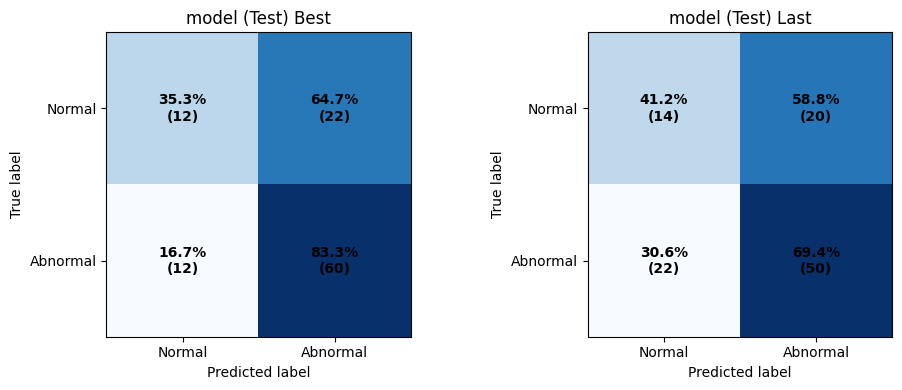

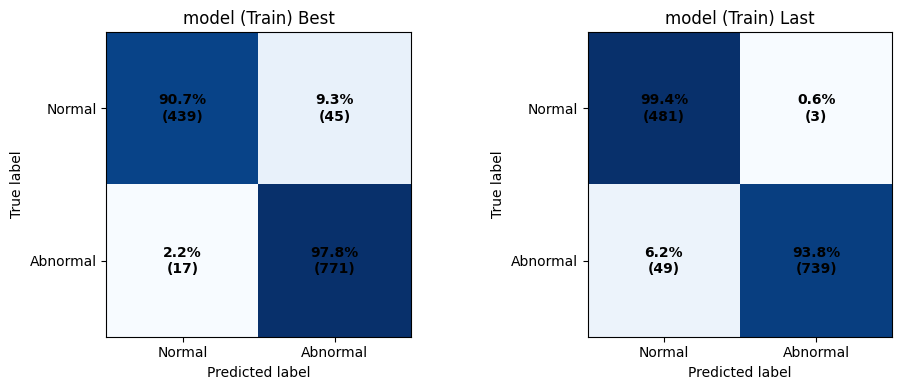

In [153]:
plot_side_by_side_confusions(model_best, model_last, test_loader_feats, "model (Test)")
plot_side_by_side_confusions(model_best, model_last, train_loader_feats, "model (Train)")

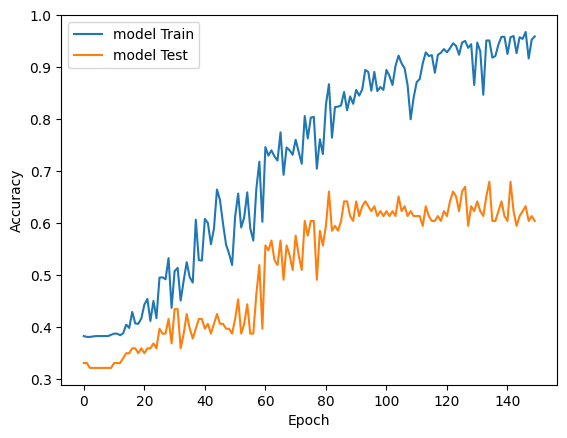

In [154]:
plt.plot(train_acc, label="model Train")
plt.plot(test_acc, label="model Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#redundance

In [ ]:
# def train_model(model, train_loader, test_loader, epochs=10, lr=1e-4, device="cuda"):
#     model.to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

#     train_acc_list, test_acc_list = [], []

#     for epoch in range(epochs):
#         model.train()
#         correct, total, running_loss = 0, 0, 0.0
#         for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
#             imgs, labels = imgs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(imgs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * imgs.size(0)
#             preds = outputs.argmax(1)
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)

#         train_acc = correct / total
#         train_acc_list.append(train_acc)

#         # Evaluation
#         model.eval()
#         correct, total = 0, 0
#         with torch.no_grad():
#             for imgs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Eval]"):
#                 imgs, labels = imgs.to(device), labels.to(device)
#                 preds = model(imgs).argmax(1)
#                 correct += (preds == labels).sum().item()
#                 total += labels.size(0)

#         test_acc = correct / total
#         test_acc_list.append(test_acc)

#         print(f"Epoch [{epoch+1}/{epochs}] | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

#     return train_acc_list, test_acc_list

In [ ]:
# # --- Train VGG16 ---
# vgg = build_vgg16()
# vgg_train_acc, vgg_test_acc = train_model(vgg, train_loader, test_loader, epochs=10, device="cuda")

In [ ]:
# # --- Train ResNet152 ---
# resnet = build_resnet152()
# res_train_acc, res_test_acc = train_model(resnet, train_loader, test_loader, epochs=10, device="cuda")

In [ ]:
# plt.plot(vgg_train_acc, label="VGG16 Train")
# plt.plot(vgg_test_acc, label="VGG16 Test")
# plt.plot(res_train_acc, label="ResNet152 Train")
# plt.plot(res_test_acc, label="ResNet152 Test")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()


In [ ]:
# from torch.utils.data import DataLoader

# dataset = ColposcopyAugmentedDataset(prepared_data, root_dir=root)

# print("Total dataset length:", len(dataset))
# # should be 16 × len(prepared_data)

# img, lbl = dataset[0]
# print(img.shape, lbl)


In [ ]:
# def get_folder_id_by_path(service, path_list, parent_id="root"):
#     for name in path_list:
#         results = service.files().list(
#             q=f"'{parent_id}' in parents and name='{name}' and trashed=false",
#             fields="files(id, name, mimeType, shortcutDetails)"
#         ).execute()
#         files = results.get('files', [])
#         if not files:
#             raise ValueError(f"Folder {name} not found under parent {parent_id}")
#         f = files[0]
#         if f['mimeType'] == "application/vnd.google-apps.shortcut":
#             parent_id = f['shortcutDetails']['targetId']
#         else:
#             parent_id = f['id']
#     return parent_id

# folder_path_list = ["Colposcopy", "Data", "Patient records", "Labeled Folder"]
# folder_id = get_folder_id_by_path(service, folder_path_list)

In [ ]:
# folder_mimetype = "application/vnd.google-apps.shortcut"

# folder_path = "MyDrive/Colposcopy/Data/Patient records/Labeled Folder"

In [ ]:
# # Step 1: Check if it's a shortcut
# if folder_mimetype == "application/vnd.google-apps.shortcut":
#     shortcut_file = service.files().get(
#         fileId=folder_id,
#         fields="id, name, mimeType, shortcutDetails"
#     ).execute()
#     print(shortcut_file)
#     # Get the real folder ID
#     # folder_id = shortcut_file['shortcutDetails']['targetId']
#     folder_mimetype = "application/vnd.google-apps.folder"

In [ ]:
# def list_folders(service, parent_id, mimetype):
#     query = f"'{parent_id}' in parents and mimeType='{mimetype}' and trashed=false"
#     folders = []
#     page_token = None
#     while True:
#         response = service.files().list(
#             q=query,
#             spaces='drive',
#             fields='nextPageToken, files(id, name, owners)',
#             pageToken=page_token
#         ).execute()
#         for file in response.get('files', []):
#             folders.append(file)
#         page_token = response.get('nextPageToken', None)
#         if page_token is None:
#             break
#     return folders

# folders = list_folders(service, folder_id, folder_mimetype)


In [ ]:
# owner_dict = {}

# for f in folders:
#     for owner in f.get('owners', []):
#         email = owner.get('emailAddress')
#         if email not in owner_dict:
#             owner_dict[email] = []
#         owner_dict[email].append(f['name'])

# # Print the dictionary
# for owner, folder_list in owner_dict.items():
#     print(owner, ":", len(folder_list), "folders")


In [ ]:
# import json
# mapping_path = "/content/drive/MyDrive/Colposcopy/Data/Patient records/owner_folder_mapping.json"
# with open(mapping_path, "w") as f:
#     json.dump(owner_dict, f, indent=2)

# print(f"\n✅ Done! Mapping saved to {mapping_path}")

In [ ]:
# import os
# os.makedirs("/content/drive/MyDrive/Colposcopy/Data/Patient records/Labeled Folder Splited", exist_ok = True)

In [ ]:
# from tqdm import tqdm
# import shutil

# email_foldername_pair = {"parisa.razzazi@gmail.com" : "Parisa.R",
# "parisaonthemoon@gmail.com" : "Parisa.mohammadi",
# "deniz.mostafazadegan@gmail.com" : "Deniz"}

# for email, folders in owner_dict.items():
#     print(f"\nCopying {len(folders)} folders for {email} ...")
#     os.makedirs(f"/content/drive/MyDrive/Colposcopy/Data/Patient records/Labeled Folder Splited/{email_foldername_pair[email]}", exist_ok= True)
#     c = 0
#     for f in tqdm(folders):
#         source_dir_name = os.path.join("/content/drive/MyDrive/Colposcopy/Data/Patient records/Labeled Folder",f)
#         target_dir_name = os.path.join(f"/content/drive/MyDrive/Colposcopy/Data/Patient records/Labeled Folder Splited/{email_foldername_pair[email]}",f)
#         c += 1
#         if not os.path.exists(target_dir_name):
#             shutil.copytree(source_dir_name, target_dir_name)
#     print(c)